### Model comparison - infection cycle

Example of how to compare pyPM.ca model behaviours. Take apart the infection cycle and compare with ODE behaviour.

For these studies, no need to access data, so no need to start the GUI. Although the GUI (ipypm) can be useful to remind you of the names of the populations and parameters etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pypmca import Model, Parameter

In [2]:
ref1_model = Model.open_file('models/covid19/reference/ref_model_1.pypm')
ref2_model = Model.open_file('models/covid19/reference/ref_model_2.pypm')
refs = [ref1_model, ref2_model]

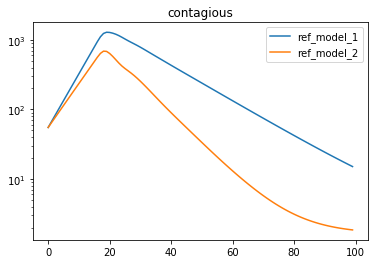

In [3]:
# compare the contagious for 100 days
n_days = 100
n_step = n_days - 1
def plot_history(models, pop_name, scale='linear'):
    for model in models:
        model.reset()
        model.evolve_expectations(n_step)
        reported = model.populations[pop_name].history
        plt.plot(range(n_days), reported, label=model.name)
    plt.title(pop_name)
    plt.legend()
    plt.yscale(scale)
    plt.show()
    
plot_history(refs, 'contagious', scale='log')

### Look at infection cycle on its own

First look at the simplest case:

Turn off the connections that deplete the contagious population.

Make copies of the reference models for these major changes:

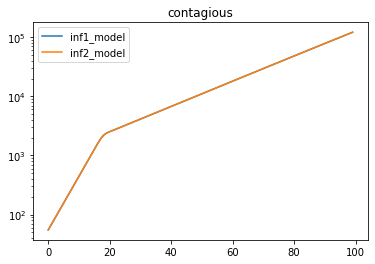

In [4]:
import copy
inf1_model = copy.deepcopy(ref1_model)
inf1_model.name = 'inf1_model'
inf2_model = copy.deepcopy(ref2_model)
inf2_model.name = 'inf2_model'

# MODEL#1 force all contagious to be non-identified -> all go to 'non_quarantined' population
inf1_model.parameters['icu_frac'].set_value(0.)
inf1_model.parameters['hosp_frac'].set_value(0.)
inf1_model.parameters['symptomatic_frac'].set_value(0.)
# don't let the non_quarantined population recover:
inf1_model.parameters['nq_recover_frac'].set_value(0.)

# MODEL#2 force all contagious to be asymptomatic -> and turn their recovery to be very late
inf2_model.parameters['contact_traced_frac'].set_value(0.)
inf2_model.parameters['symptomatic_frac'].set_value(0.)
#inf2_model.remove_connector('remove asymptomatic recoveries')
inf2_model.parameters['asymp_rec_delay_mean'].set_value(1000.)

infs = [inf1_model, inf2_model]
plot_history(infs, 'contagious', scale='log')

### The two models have identical infection cycles
The key infection cycle parameters that these models share are:
* alpha_0 = 0.385, alpha_1 = 0.062 (transmission rates before and after the transition)
* trans_rate_1_time = 16 (day that the transition in transmission rates occur)
* cont_0 = 55 (number of contagious individuals on day 0)
* cont_frac = 0.900 (fraction of infected that become contagious)
* two parameters that specify the delay between becoming infected and becoming contagious:
  * cont_delay_mean = 2.000 
  * cont_delay_sigma = 1.000
  
Consider an infection cycle that mimicks an ODE: set the delay distribution to be erlang (gamma distribution with integer k):

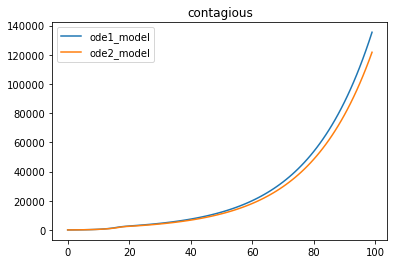

In [5]:
ode1_model = copy.deepcopy(inf1_model)
ode1_model.name = 'ode1_model'
ode2_model = copy.deepcopy(inf2_model)
ode2_model.name = 'ode2_model'

k = Parameter('k', 1, description='erlang k', parameter_type='int', parameter_max = 4)
cont_delay_mean1 = ode1_model.parameters['cont_delay_mean']
ode1_model.delays['cont_delay'].setup_delay('erlang',{'mean':cont_delay_mean1, 'k':k})

# show effect of changing delay distribution: very small
odes = [ode1_model, ode2_model]
plot_history(odes, 'contagious', scale='linear')

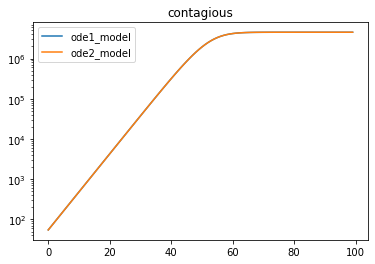

In [6]:
# now change model 2 also

cont_delay_mean2 = ode2_model.parameters['cont_delay_mean']
ode2_model.delays['cont_delay'].setup_delay('erlang',{'mean':cont_delay_mean2, 'k':k})

# turn off the transition in alpha
for model in odes:
    model.transitions['trans_rate_1'].enabled = False

plot_history(odes, 'contagious', scale='log')

alpha= 0.4
cdm1 =  2.0
eta =  0.24099789583271375


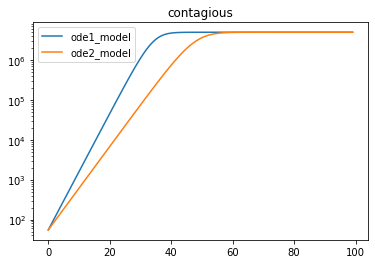

cdm1 =  0.001
eta =  0.3364534397019978


In [7]:
# find the exponential parameter, letting all infected to become contagions
odes[0].parameters['cont_frac'].set_value(1.0)
odes[1].parameters['cont_frac'].set_value(1.0)
alpha = 0.4
odes[0].parameters['alpha_0'].set_value(alpha)
odes[1].parameters['alpha_0'].set_value(alpha)
print('alpha=',alpha)

t=10
cont_delay_mean1.set_value(2.)
odes[0].reset()
odes[0].evolve_expectations(n_step)
print('cdm1 = ',cont_delay_mean1.get_value())
c0 = odes[0].populations['contagious'].history[0]
ct = odes[0].populations['contagious'].history[t]
eta = 1./t * np.log(ct/c0)
print('eta = ',eta)

cont_delay_mean1.set_value(0.001)
plot_history(odes, 'contagious', scale='log')
c0 = odes[0].populations['contagious'].history[0]
ct = odes[0].populations['contagious'].history[t]
eta = 1./t * np.log(ct/c0)
print('cdm1 = ',cont_delay_mean1.get_value())
print('eta = ',eta)

cont_delay_mean1.set_value(2.)

alpha= 0.2


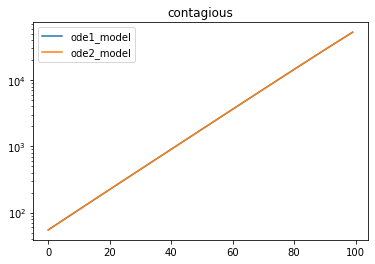

cdm1 =  2.0
eta =  0.07050145899678642


In [8]:
# for large alpha (eg. 0.385), the value for the exponential constant, eta is smaller: around 0.325 
# As alpha -> 0, eta is very close to alpha. Appears that this an artifact of the implementation with discrete time.
# With smaller alpha, it is effectively the same system with a reduced time step.
# Now turn on a simple recovery: 

alpha = 0.2
odes[0].parameters['alpha_0'].set_value(alpha)
odes[1].parameters['alpha_0'].set_value(alpha)
print('alpha=',alpha)

rec_delay = 10.
cont_delay_mean1.set_value(2.)

# now let the non_quarantined population recover:
ode1_model.parameters['nq_recover_frac'].set_value(1.)
recover_delay_mean = ode1_model.parameters['recover_delay_mean']
recover_delay_mean.set_value(rec_delay)
ode1_model.delays['recover_delay'].setup_delay('erlang',{'mean':recover_delay_mean, 'k':k})
recover_delay_mean

#inf2_model.remove_connector('remove asymptomatic recoveries')
asymp_rec_delay_mean = ode2_model.parameters['asymp_rec_delay_mean']
asymp_rec_delay_mean.set_value(rec_delay)
ode2_model.delays['asymp_rec_delay'].setup_delay('erlang',{'mean':asymp_rec_delay_mean, 'k':k})

plot_history(odes, 'contagious', scale='log')
c0 = odes[0].populations['contagious'].history[0]
ct = odes[0].populations['contagious'].history[t]
eta = 1./t * np.log(ct/c0)
print('cdm1 = ',cont_delay_mean1.get_value())
print('eta = ',eta)

### Reproduction number

It appears that R = alpha * rec_delay (approximately). (As is known from ODE solution)
When that product is less than 1, the model cannot boot (no growth) and when close to 1, it does, with very small growth.
It has just a weak dependence on the mean delay from infected to contagious.

Now go to the Gaussian delays:

alpha= 0.166


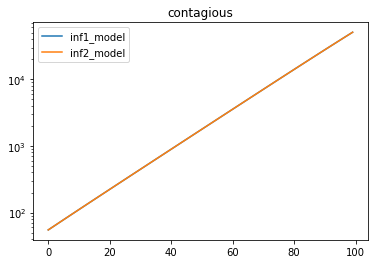

cdm1 =  2.0
eta =  0.07044590915969132


In [9]:
alpha = 0.166
print('alpha=',alpha)

rec_delay = 10.
rec_sigma = 2.

# turn off the transition in alpha, let all infected become contagious as above
for model in infs:
    model.parameters['alpha_0'].set_value(alpha)
    model.parameters['cont_frac'].set_value(1.0)
    model.transitions['trans_rate_1'].enabled = False
    
# let the non_quarantined population recover:
inf1_model.parameters['nq_recover_frac'].set_value(1.)
inf1_model.parameters['recover_delay_mean'].set_value(rec_delay)
inf1_model.parameters['recover_delay_sigma'].set_value(rec_sigma)

inf2_model.parameters['asymp_rec_delay_mean'].set_value(rec_delay)
inf2_model.parameters['asymp_rec_delay_sigma'].set_value(rec_sigma)

plot_history(infs, 'contagious', scale='log')

c0 = infs[0].populations['contagious'].history[0]
ct = infs[0].populations['contagious'].history[t]
eta = 1./t * np.log(ct/c0)
print('cdm1 = ',cont_delay_mean1.get_value())
print('eta = ',eta)

### Reproduction number for Gaussian delay

Very similar behaviour seen for the steady state solution. critical value for growth is alpha * mean_delay > 1.
However, the exponential slope differs from the erlang slope by almost a factor of 2 when alpha = 0.1 and mean_delay = 10.
The ratio is closer to 1 for larger alpha

These studies illustrate the fact that the steady state growth by itself is not sufficient to estimate R

The growth for ODE: alpha = 0.2, INF: alpha = 0.166 are similar... with that look at transitions:

### Transitions

Now turn back on the transition for alpha and compare the behavior for the ODE and Gaussian delays. The INF model takes more time to transition into a steady state solution (as expected). The contagious population declines much more quickly.

The ODE transition (k=1) 

alpha_0 = 0.2 -> alpha_1 = 0.062 

is mimicked in the INF model with

alpha_0 = 0.166 -> alpha_1 = 0.077

Changing the ODE k value to a large number (like 25) the ODE and INF are identical (but not practical for a real ODE). For k=3, there remain large differences:

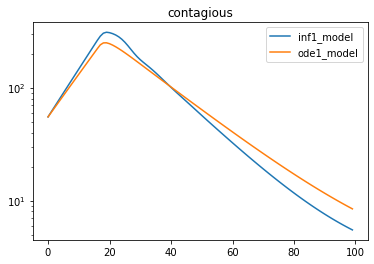

In [10]:
comps = [inf1_model, ode1_model]
inf1_model.parameters['alpha_0'].set_value(0.2)
inf1_model.parameters['alpha_1'].set_value(0.062)
k.set_value(3)
for model in comps:
    model.transitions['trans_rate_1'].enabled = True
    
plot_history(comps, 'contagious', scale='log')